# CIBer Example: BankChurner
This [Bankchurner](https://www.kaggle.com/code/thomaskonstantin/bank-churn-data-exploration-and-churn-prediction/data) dataset by Thomas Konstantin is used to illustrate the application of CIBer in Python.

## Load all required libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from CIBer import CIBer
import matplotlib.pyplot as plt

/Users/kaiser/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataset preprocessing

In [2]:
dataset = "BankChurners"
df = pd.read_csv(f"Dataset/{dataset}.csv")

# Drop unused columns
df.drop(columns=['CLIENTNUM', 
                 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], inplace=True)

# Encode categorical feature values into discrete ones
df['Attrition_Flag'] = pd.factorize(df['Attrition_Flag'])[0] + 0
df['Gender'] = pd.factorize(df['Gender'])[0] + 1
df['Education_Level'] = pd.factorize(df['Education_Level'])[0] + 1
df['Marital_Status'] = pd.factorize(df['Marital_Status'])[0] + 1
df['Income_Category'] = pd.factorize(df['Income_Category'])[0] + 1
df['Card_Category'] = pd.factorize(df['Card_Category'])[0] + 1

# Move label y to the last column of df
cols = df.columns.to_list()
cols.append(cols[0])
cols = cols[1:]
df = df[cols]

## Sampling and Train-test split
Since this dataset is highly imbalance, we sample 7000 datapoints as the training dataset and then pick 200 datapoints in each class as the test dataset

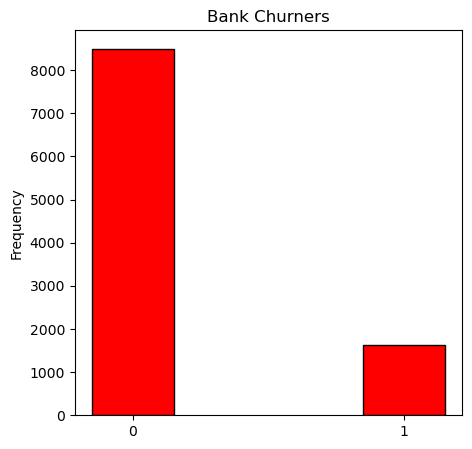

In [3]:
# Dataset preparation
label_name = "Attrition_Flag"
df_bank_y = df[label_name]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
settings = {"rwidth":0.3, "bins":[-.5,.5,1.5], "xticks":(0, 1), "ec":"k"}
df_bank_y.plot.hist(**settings, title="Bank Churners", color="red")

n_sample = 7000
n_test = 200

np.random.seed(4012)
idx_train = np.random.choice(np.arange(len(df)), n_sample, replace=False)
X_train = df.iloc[idx_train,:-1].to_numpy()
y_train = df.iloc[idx_train,-1].to_numpy()

# obtain test. 1500 in EACH class
samples_per_group_dict = {0:n_test, 1:n_test}
df_test = df[~df.index.isin(idx_train)]
df_test = df_test.groupby(label_name).apply(lambda group: group.sample(samples_per_group_dict[group.name])).reset_index(drop=True)
X_test = df_test.iloc[:,:-1].to_numpy()
y_test = df_test.iloc[:,-1].to_numpy()

In [4]:
col_idx = pd.Series(np.arange(len(df.columns.values)), index=df.columns.values)
ncount = df.apply(lambda col: len(np.unique(col)), axis=0)
print(pd.concat([col_idx, ncount], axis=1))

                           0     1
Customer_Age               0    45
Gender                     1     2
Dependent_count            2     6
Education_Level            3     7
Marital_Status             4     4
Income_Category            5     6
Card_Category              6     4
Months_on_book             7    44
Total_Relationship_Count   8     6
Months_Inactive_12_mon     9     7
Contacts_Count_12_mon     10     7
Credit_Limit              11  6205
Total_Revolving_Bal       12  1974
Avg_Open_To_Buy           13  6813
Total_Amt_Chng_Q4_Q1      14  1158
Total_Trans_Amt           15  5033
Total_Trans_Ct            16   126
Total_Ct_Chng_Q4_Q1       17   830
Avg_Utilization_Ratio     18   964
Attrition_Flag            19     2


## Fit CIBer and make predictions

cont_col is a list of indices for the continuous feature variables

min_asso is the minimum threshold adopted in measuring the linear association given any pairs of feature variables. This can be found by grid-search.

In [21]:
# parameters to be added in CIBer
cont_col = [7, 11, 12, 13, 14, 15, 16, 17, 18]
min_asso = 0.95

# Fit CIBer
CIBer_clf = CIBer(cont_col=cont_col, asso_method='total_order', min_asso=min_asso, 
                  disc_method="auto", n_bins=50, joint_encode=True)
CIBer_clf.fit(X_train, y_train)
CIBer_predict = CIBer_clf.predict(X_test)
CIBer_proba = CIBer_clf.predict_proba(X_test)

# Retreive Comonotonic clusters
print(CIBer_clf.cluster_book)
print(df.columns.values[[6, 11]])
print(df.columns.values[[6, 11]])

{0: [[0], [1], [2], [3], [4], [5], [6, 11], [7], [8], [9], [10], [12], [13], [14], [15], [16], [17], [18]], 1: [[0], [1], [2], [3], [4], [5], [6, 11], [7], [8], [9], [10], [12], [13], [14], [15], [16], [17], [18]]}
['Card_Category' 'Credit_Limit']
['Card_Category' 'Credit_Limit']


For both the labels 0 and 1, they have the same comonotonic cluster, i.e. 'Card_Category' and 'Credit_Limit'. In particular, 'Card_Category' is a categorical feature variable representing the level of the credit card. It is then obvious that a higher level of cards would yield a greater amount in 'Credit_Limit'.

## Model assessment

In [22]:
print("AUROC", roc_auc_score(y_test, CIBer_proba[:,1]))
print("Precision", precision_score(y_test, CIBer_predict))
print("Recall", recall_score(y_test, CIBer_predict))
print("F1", f1_score(y_test, CIBer_predict))
print("Accuracy", accuracy_score(y_test, CIBer_predict))

AUROC 0.96315
Precision 0.9506172839506173
Recall 0.77
F1 0.850828729281768
Accuracy 0.865
